In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/paddy-disease-classification/sample_submission.csv
/kaggle/input/paddy-disease-classification/train.csv
/kaggle/input/paddy-disease-classification/train_images/tungro/109629.jpg
/kaggle/input/paddy-disease-classification/train_images/tungro/104765.jpg
/kaggle/input/paddy-disease-classification/train_images/tungro/109706.jpg
/kaggle/input/paddy-disease-classification/train_images/tungro/100098.jpg
/kaggle/input/paddy-disease-classification/train_images/tungro/102734.jpg
/kaggle/input/paddy-disease-classification/train_images/tungro/106433.jpg
/kaggle/input/paddy-disease-classification/train_images/tungro/108930.jpg
/kaggle/input/paddy-disease-classification/train_images/tungro/102019.jpg
/kaggle/input/paddy-disease-classification/train_images/tungro/102416.jpg
/kaggle/input/paddy-disease-classification/train_images/tungro/101046.jpg
/kaggle/input/paddy-disease-classification/train_images/tungro/108310.jpg
/kaggle/input/paddy-disease-classification/train_images/tungro/10402

In [2]:
from fastai.vision.all import *

In [3]:
path = '/kaggle/input/paddy-disease-classification/'
trn_path = path + 'train_images'
df = pd.read_csv(path + 'train.csv', index_col='image_id')
df.head()


,label,variety,age
image_id,,,
100330.jpg,bacterial_leaf_blight,ADT45,45
100365.jpg,bacterial_leaf_blight,ADT45,45
100382.jpg,bacterial_leaf_blight,ADT45,45
100632.jpg,bacterial_leaf_blight,ADT45,45
101918.jpg,bacterial_leaf_blight,ADT45,45


In [4]:
def get_variety(p): return df.loc[p.name, 'variety']

In [5]:
dls = DataBlock(
    blocks=(ImageBlock,CategoryBlock,CategoryBlock),
    n_inp=1,
    get_items=get_image_files,
    get_y = [parent_label,get_variety],
    splitter=RandomSplitter(0.2, seed=42),
    item_tfms=Resize(192, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75)
).dataloaders(trn_path)

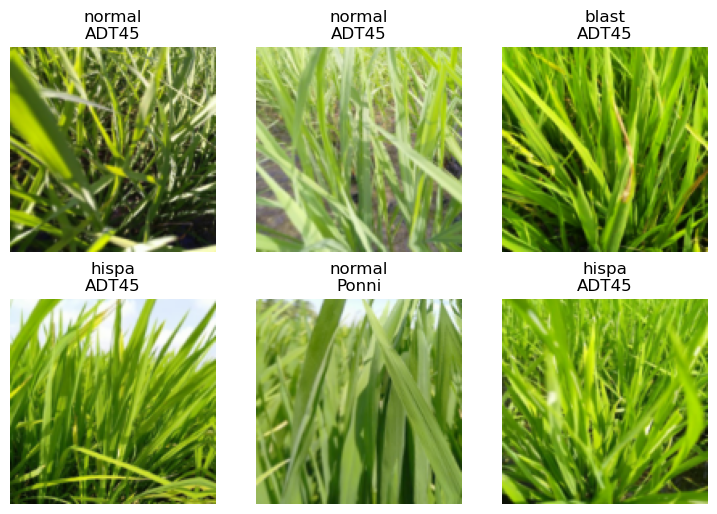

In [6]:
dls.show_batch(max_n=6)

In [7]:
def disease_err(inp,disease,variety): return error_rate(inp,disease)
def disease_loss(inp,disease,variety): return F.cross_entropy(inp,disease)

In [8]:
arch = 'convnext_small_in22k'
learn = vision_learner(dls, arch, loss_func=disease_loss, metrics=disease_err, n_out=10).to_fp16()
lr = 0.01

/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


In [9]:
learn.fine_tune(5, lr)

epoch,train_loss,valid_loss,disease_err,time
0,1.228074,0.915461,0.274387,04:00


epoch,train_loss,valid_loss,disease_err,time
0,0.650843,0.475985,0.144161,04:05
1,0.512333,0.326271,0.101874,03:49
2,0.311104,0.189363,0.062951,03:48
3,0.183147,0.137380,0.038924,03:47
4,0.138648,0.123764,0.037001,03:48


In [10]:
learn = vision_learner(dls, arch, n_out=20).to_fp16()

In [11]:
def disease_loss(inp,disease,variety): return F.cross_entropy(inp[:,:10],disease)
def variety_loss(inp,disease,variety): return F.cross_entropy(inp[:,10:],variety)
def combine_loss(inp,disease,variety): return disease_loss(inp,disease,variety)+variety_loss(inp,disease,variety)

In [12]:
def disease_err(inp,disease,variety): return error_rate(inp[:,:10],disease)
def variety_err(inp,disease,variety): return error_rate(inp[:,10:],variety)

err_metrics = (disease_err,variety_err)
all_metrics = err_metrics+(disease_loss,variety_loss)

In [13]:
learn = vision_learner(dls, arch, loss_func=combine_loss, metrics=all_metrics, n_out=20).to_fp16()

In [14]:
learn.fine_tune(5, lr)

epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,2.254791,1.170205,0.249399,0.121576,0.793076,0.377130,03:53


epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,1.025293,0.634970,0.148486,0.059587,0.439875,0.195095,03:57
1,0.756520,0.480894,0.104277,0.051898,0.333269,0.147625,03:48
2,0.481733,0.282618,0.057184,0.024988,0.193822,0.088796,03:48
3,0.290590,0.179190,0.047093,0.011052,0.139097,0.040093,04:05
4,0.203421,0.167874,0.039885,0.012013,0.126718,0.041155,04:07
